![](https://www.domsoria.com/wp-content/uploads/2019/11/keras.png)

# Evaluating a Learning Algorithm

We are in the tough situation of wondering whether our algorithm makes "good" predictions. 

And what the hell does it mean "good"?

Let's see!

In [1]:
# Import libraries
import time
import numpy as np
import pandas as pd
import h5py
import matplotlib.pyplot as plt
import scipy
from PIL import Image
from scipy import ndimage

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from sklearn.linear_model import LogisticRegression

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import plot_model
from tensorflow.keras import optimizers

import skimage.transform
import imageio

%matplotlib inline
%config InlineBackend.figure_format = "retina"
plt.rcParams['figure.figsize'] = (5.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

np.random.seed(1)

## Error Metrics

Until now, we evaluated our algorithms using *accuracy* on the test set, meaning how many right answers our algorithm is able to predict correctly.

Concretely,

$$ A = \frac{y_{pred}}{y} \, .$$

Let's study the following example.

We want to predict whether someone has a cancer or not. Training a classifier, we find out that we get a $1\%$ error on the test set, meaning we make $99\%$ of correct diagnosis.

However, in our dataset we have that only $0.3\%$ of patients has cancer.

Thus, let's consider the following "prediction" algorithm.

```python
    def is_cancer(x):
        y = 0 # No matter the value of x
        return y
```

__Question__: Can you calculate the accuracy of such a model? How many correct diagnosis it will return?

In most cases, we are not only interested in how many correct (positive) answers we get, but also in how many negative answers are predicted as actually negative.

In order to get these scores, we have to define different __error metrics__. 

For a binary classification problem, these are the most common. One can find a numerous set of metrics in the [`sklearn` documentation](https://scikit-learn.org/stable/modules/model_evaluation.html).

* [Precision](https://en.wikipedia.org/wiki/Precision_and_recall)
* [Recall](https://en.wikipedia.org/wiki/Precision_and_recall)
* [$F_1$-score](https://en.wikipedia.org/wiki/F1_score)
* [ROC-AUC](https://en.wikipedia.org/wiki/Receiver_operating_characteristic)

#### Precision and Recall

![title](https://upload.wikimedia.org/wikipedia/commons/thumb/2/26/Precisionrecall.svg/700px-Precisionrecall.svg.png)

These are faces of the same coin. 

Indeed, __precision__ is the fraction of true positives (_i.e._ $y = 1$ and $y_{pred} = 1$) over the total number of predicted positives ($y_{pred} = 1$).

On the other hand, __recall__ is the fraction of true positives (_i.e._ $y = 1$ and $y_{pred} = 1$) over the total number of actual positives ($y = 1$).

In our oncological example, we can rephrase as follows,

* __Precision__: Of all patients we predicted have cancer, what fraction actually has a cancer?
* __Recall__: Of all patients that actually have a cancer, what fraction we correctely predict having a cancer?

Using such metrics, in our example we have for the classifier algorithm

|Model | Precision | Recall |
|--|---|----|
|__logistic regression__ | 97% | 89% | 
|__deterministic__ | - | 0% |


We now have a numeric measure to determine when an algorithm is good or not, even in a tough case like the one above.

#### $F_1$-score

A metric that combines the scores from _precision_ and _recall_ is the so-called $F_1$-score, defined as follows,

$$ F_1 = 2 \frac{P R}{P+R}\, ,$$

__Question__: Calculate the $F_1$ scores of both algorithms above.

## Confusion Matrix

We can put the concepts above into a matrix. 

For a binary classification problem, like the cancer diagnosis one, we may put in one axis the true labels vs the predicted ones.

First of all, let's load the dataset.

In [2]:
cancer = load_breast_cancer()
df_cancer = pd.DataFrame(cancer.data, columns = cancer.feature_names)
df_cancer['target'] = cancer.target
X = df_cancer.loc[:, cancer.feature_names]
y = df_cancer.target

Split data into training and test sets.

In [3]:
# Split the data into a training set and a test set
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

Then let's fit the model

In [4]:
model = LogisticRegression(solver = 'newton-cg')
model.fit(X_train, y_train)

LogisticRegression(solver='newton-cg')

In [5]:
y_pred = model.predict(X_test)

In [6]:
class_names = cancer.target_names

At this stage, we can make use of the `confusion_matrix` method of `sklearn` to compute confusion matrix for our model.

In [7]:
cm = confusion_matrix(y_test, y_pred)

print(cm)

[[52  1]
 [ 6 84]]


This is already the result. One can see in the [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html#sklearn.metrics.confusion_matrix) the meaning of numbers. 

* The $(1,1)$ entry is the number of __Real Positives__, that is $y_{pred} = y_{test} = 1$.
* The $(1,2)$ entry is the number of __False Negatives__, that is  $y_{pred} = 0$, $y_{test} = 1$.
* The $(2,1)$ entry is the number of __False Positives__, that is  $y_{pred} = 1$, $y_{test} = 0$.
* The $(2,2)$ entry is the number of __Real Negatives__, that is  $y_{pred} = y_{test} = 0$.

It might be useful (and nicer) to transform this array into something more immediate and understandable.
There are two steps one can do. 

1. The first one is transform the non-normalised numbers into relative quantitities. 
2. The second one is to associate a color scale to values.

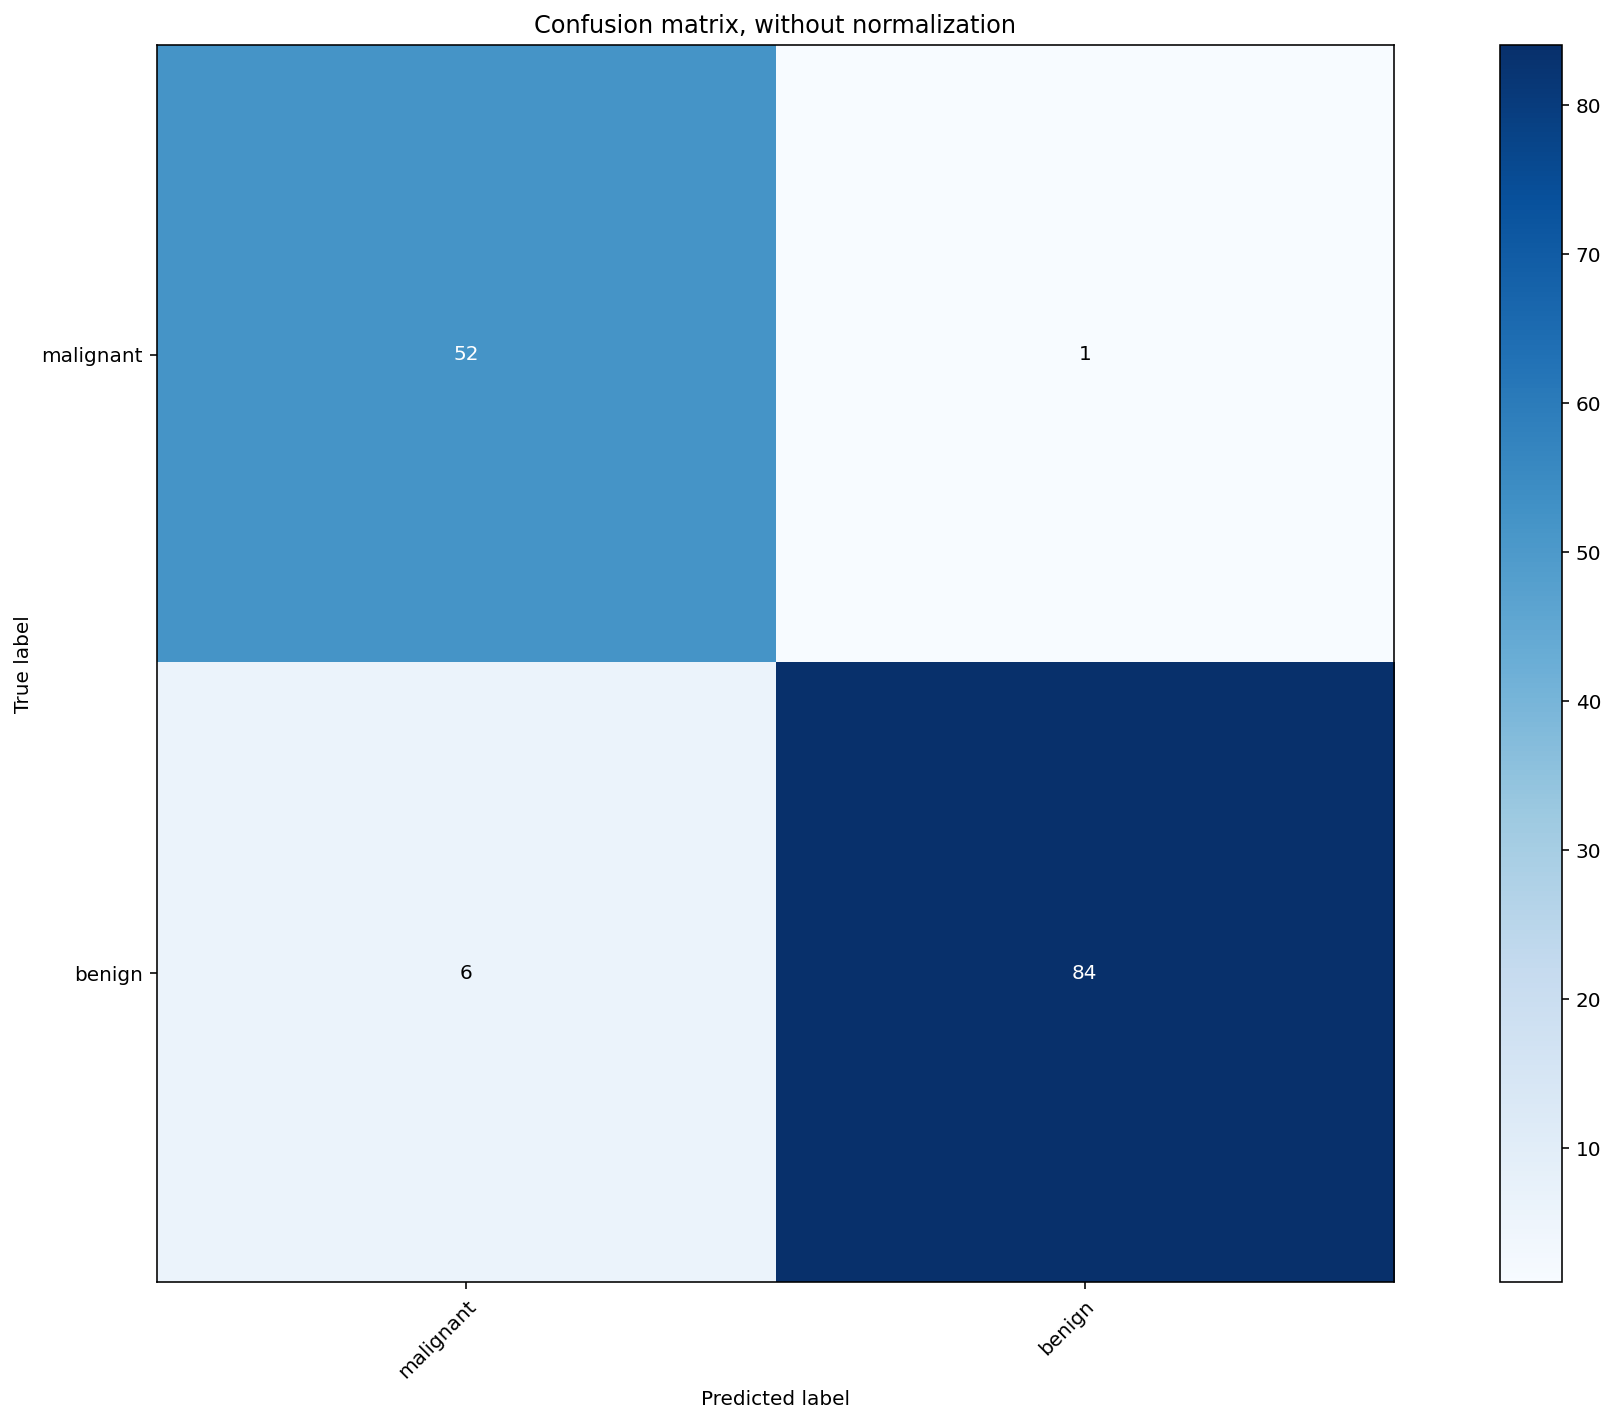

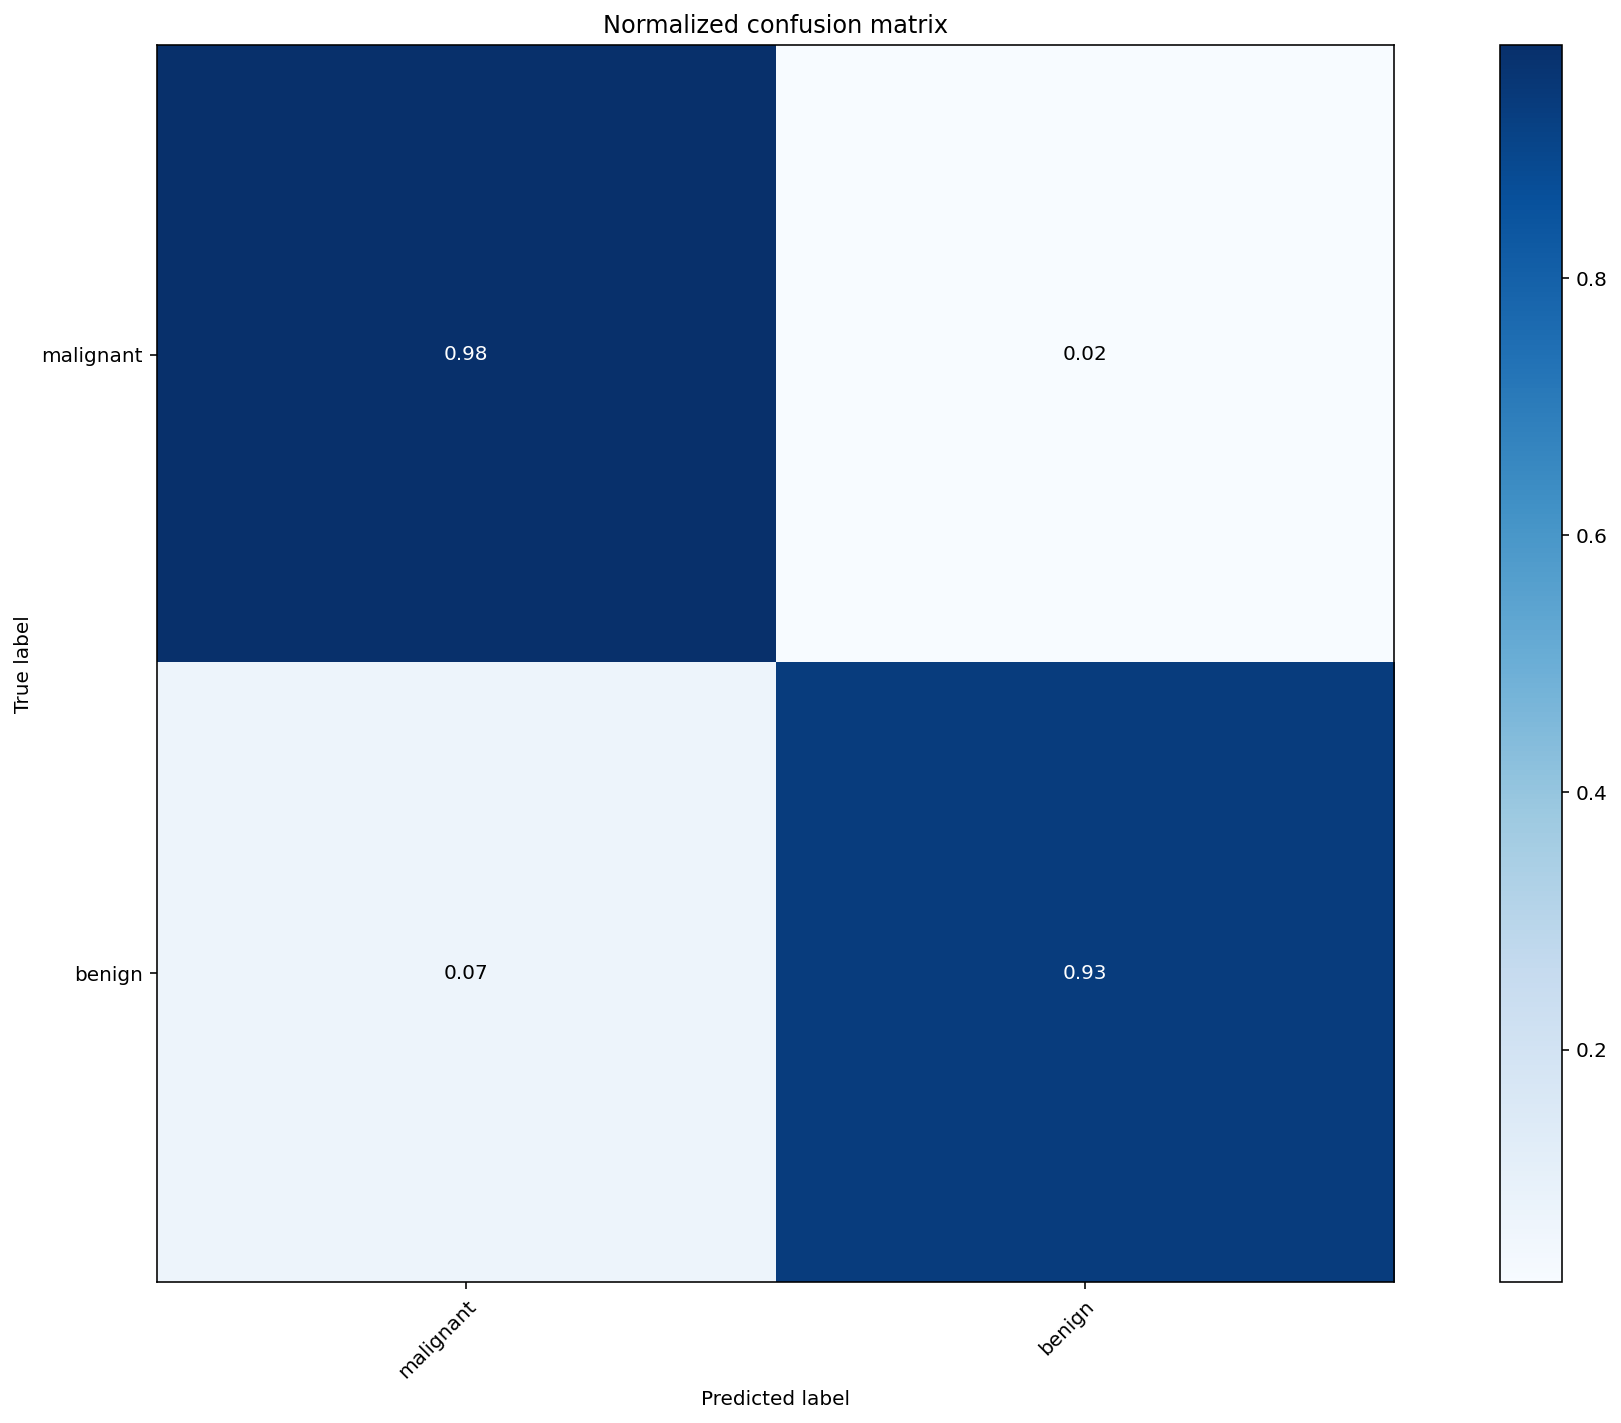

In [8]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.rcParams["figure.figsize"] = (15,10) # Change the default figure size
    
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        
    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

It is immediate from the confusion matrix to calculate precision and recall, and so $F_1$-score.

## Keras Application

A neural network classifier does not differ from a _shallow_ machine learning one concerning error metrics, so in Keras you have the metrics above and much more. It is also possible to build your own defined metric and even train your model to maximise such a metric. Indeed, both loss functions and explicitly defined Keras metrics can be used as training metrics.


First, let's see how to have classic metrics information after the training.

## Keras Regression Metrics

Below is a list of the metrics that you can use in Keras on __regression problems__.

* __Mean Squared Error__: `mean_squared_error`, `MSE` or `mse`
* __Mean Absolute Error__: `mean_absolute_error`, `MAE`, `mae`
* __Mean Absolute Percentage Error__: `mean_absolute_percentage_error`, `MAPE`, `mape`
* __Cosine Proximity__: `cosine_proximity`, `cosine`

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2022-06-28 10:25:56.068152: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-06-28 10:25:56.068280: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Epoch 1/150


2022-06-28 10:25:56.650101: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-06-28 10:25:56.927062: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 2s 2s/step - loss: 0.1958 - mse: 0.1958 - mae: 0.3922 - mape: 71.3078 - cosine_similarity: 1.0000
Epoch 2/150
1/1 [==============================] - 0s 6ms/step - loss: 0.1927 - mse: 0.1927 - mae: 0.3886 - mape: 70.3801 - cosine_similarity: 1.0000
Epoch 3/150
1/1 [==============================] - 0s 7ms/step - loss: 0.1897 - mse: 0.1897 - mae: 0.3850 - mape: 69.4525 - cosine_similarity: 1.0000
Epoch 4/150
1/1 [==============================] - 0s 7ms/step - loss: 0.1867 - mse: 0.1867 - mae: 0.3814 - mape: 68.5254 - cosine_similarity: 1.0000
Epoch 5/150
1/1 [==============================] - 0s 7ms/step - loss: 0.1837 - mse: 0.1837 - mae: 0.3778 - mape: 67.5988 - cosine_similarity: 1.0000
Epoch 6/150
1/1 [==============================] - 0s 7ms/step - loss: 0.1808 - mse: 0.1808 - mae: 0.3742 - mape: 66.6728 - cosine_similarity: 1.0000
Epoch 7/150
1/1 [==============================] - 0s 15ms/step - loss: 0.1778 - mse: 0.1778 - mae: 0.3706 - mape

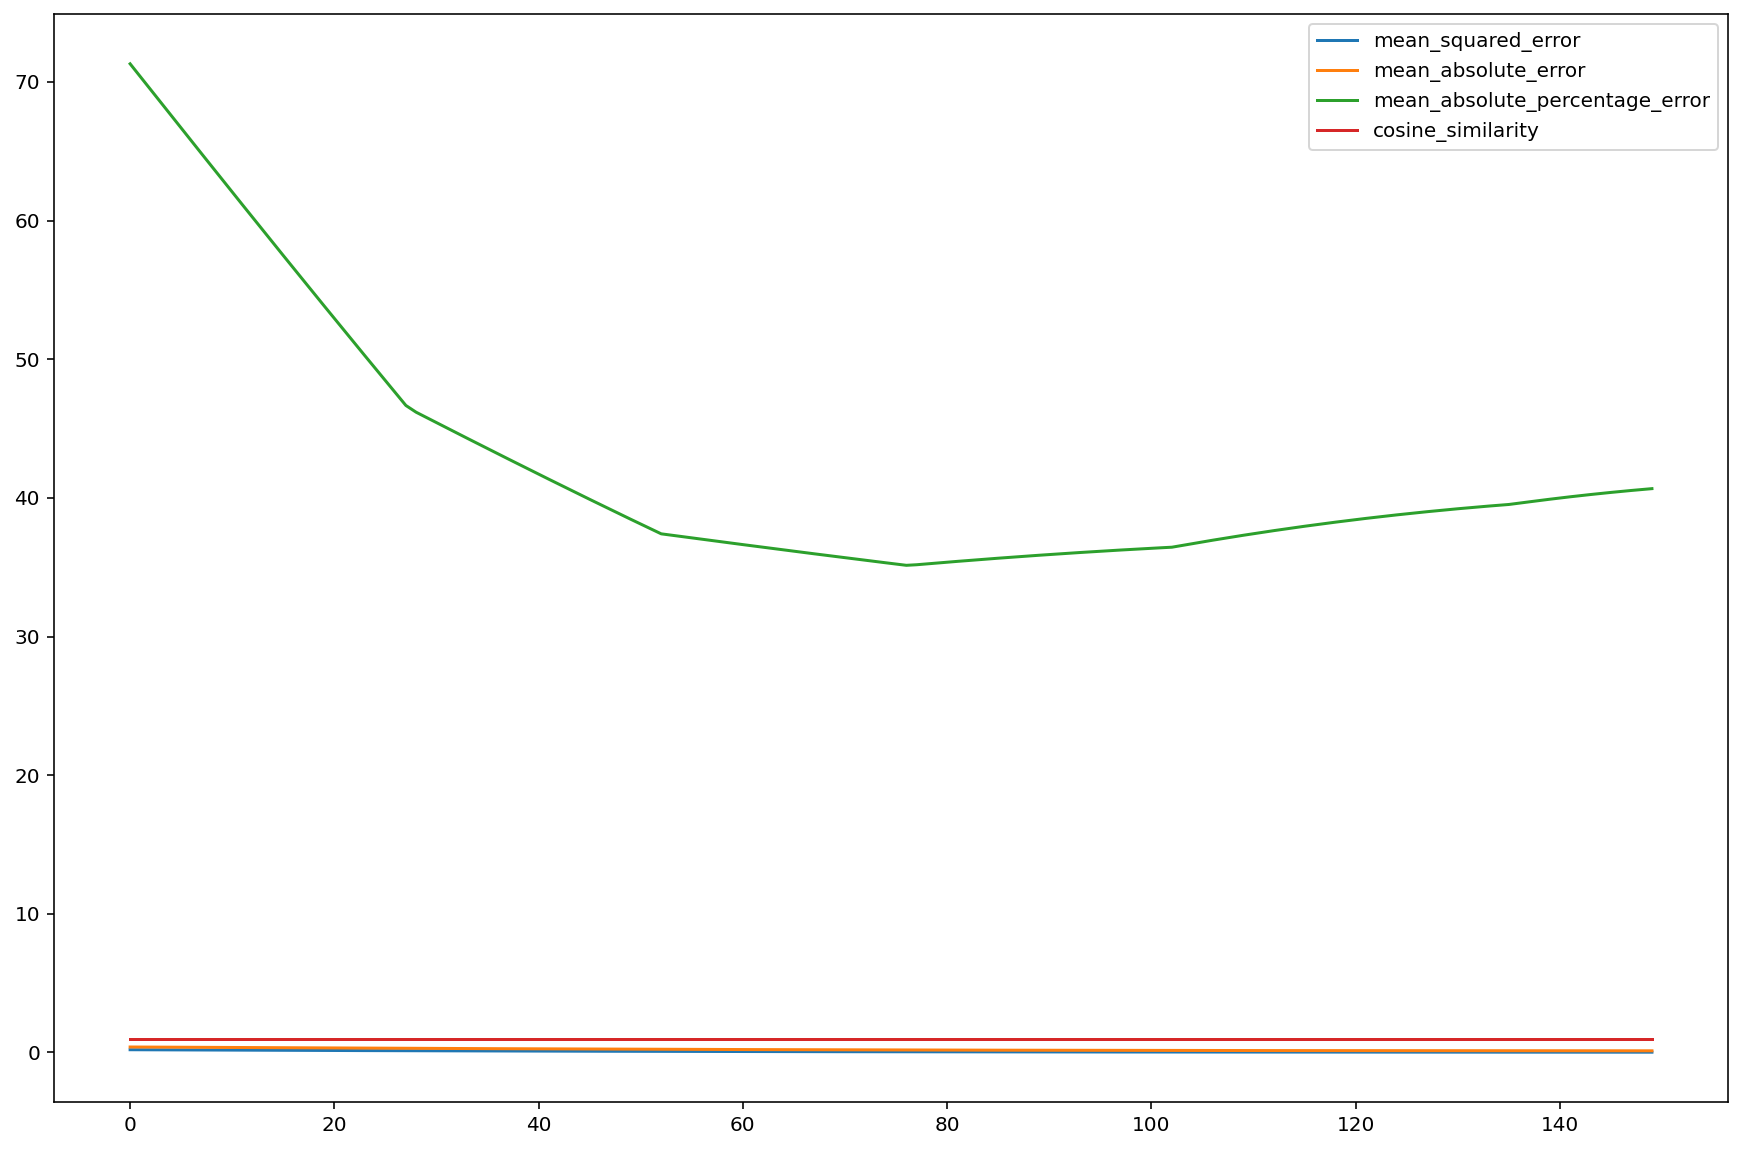

In [9]:
# prepare example sequence
X = np.array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
# create model
model = Sequential()
model.add(Dense(2, input_dim=1))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam', metrics=['mse', 'mae', 'mape', 'cosine_similarity'])
# train model
history = model.fit(X, X, epochs=150, batch_size=len(X), verbose=1)
# plot metrics
plt.plot(history.history['mse'])
plt.plot(history.history['mae'])
plt.plot(history.history['mape'])
plt.plot(history.history['cosine_similarity'])
plt.legend(['mean_squared_error', 'mean_absolute_error', 'mean_absolute_percentage_error', 'cosine_similarity'], loc='upper right')
plt.show()

## Keras Classification Metrics
Below is a list of the metrics that you can use in Keras on __classification problems__.

* __Binary Accuracy__: `binary_accuracy`, `acc`
* __Categorical Accuracy__: `categorical_accuracy`, `acc`
* __Sparse Categorical Accuracy__: `sparse_categorical_accuracy`
* __Top k Categorical Accuracy__: `top_k_categorical_accuracy` (requires you specify a `k` parameter)
* __Sparse Top k Categorical Accuracy__: `sparse_top_k_categorical_accuracy` (requires you specify a `k` parameter)

Below is an example of a binary classification problem with the built-in accuracy metric demonstrated.

Epoch 1/400


2022-06-28 10:26:04.612193: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 - 1s - loss: 0.6112 - accuracy: 0.5000 - 520ms/epoch - 520ms/step
Epoch 2/400
1/1 - 0s - loss: 0.6108 - accuracy: 0.5000 - 5ms/epoch - 5ms/step
Epoch 3/400
1/1 - 0s - loss: 0.6103 - accuracy: 0.5000 - 4ms/epoch - 4ms/step
Epoch 4/400
1/1 - 0s - loss: 0.6099 - accuracy: 0.5000 - 5ms/epoch - 5ms/step
Epoch 5/400
1/1 - 0s - loss: 0.6095 - accuracy: 0.5000 - 6ms/epoch - 6ms/step
Epoch 6/400
1/1 - 0s - loss: 0.6091 - accuracy: 0.5000 - 5ms/epoch - 5ms/step
Epoch 7/400
1/1 - 0s - loss: 0.6086 - accuracy: 0.5000 - 5ms/epoch - 5ms/step
Epoch 8/400
1/1 - 0s - loss: 0.6082 - accuracy: 0.5000 - 5ms/epoch - 5ms/step
Epoch 9/400
1/1 - 0s - loss: 0.6078 - accuracy: 0.5000 - 5ms/epoch - 5ms/step
Epoch 10/400
1/1 - 0s - loss: 0.6073 - accuracy: 0.5000 - 5ms/epoch - 5ms/step
Epoch 11/400
1/1 - 0s - loss: 0.6069 - accuracy: 0.5000 - 5ms/epoch - 5ms/step
Epoch 12/400
1/1 - 0s - loss: 0.6065 - accuracy: 0.5000 - 6ms/epoch - 6ms/step
Epoch 13/400
1/1 - 0s - loss: 0.6060 - accuracy: 0.5000 - 5ms/epoch -

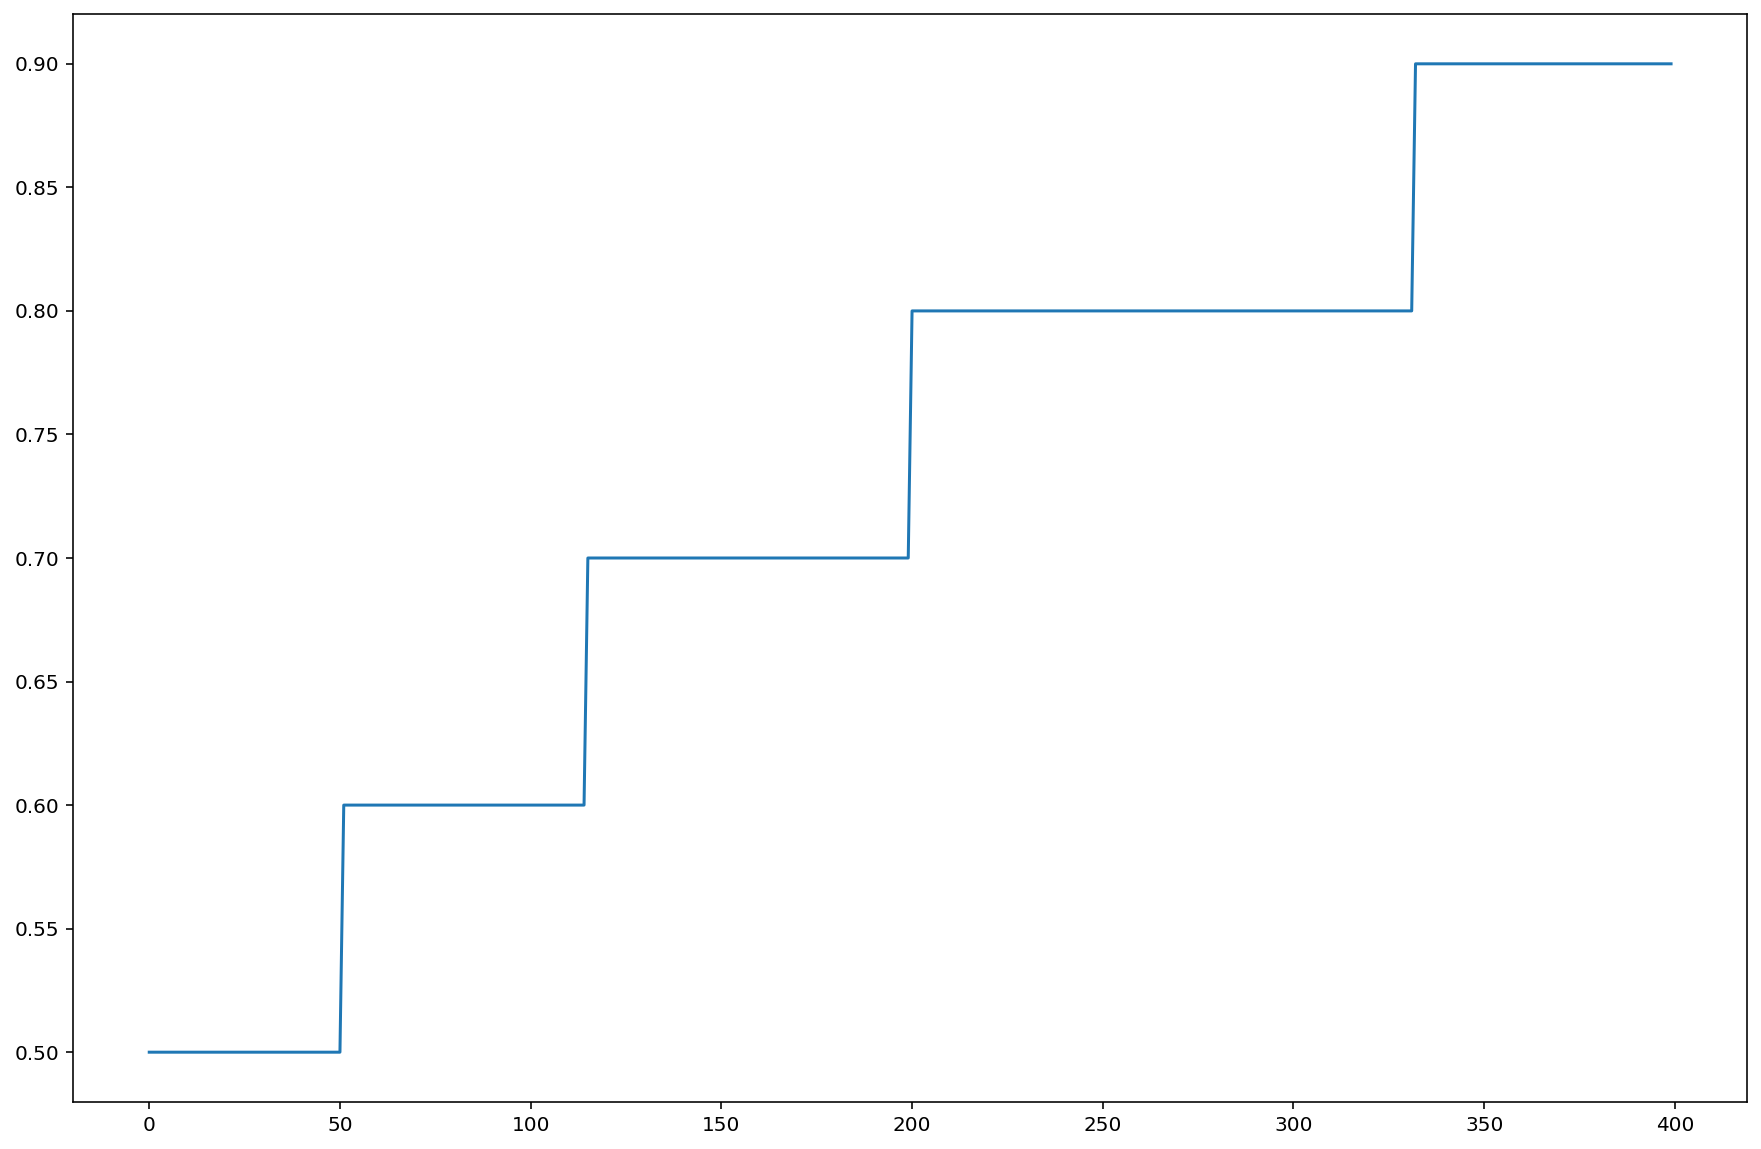

In [10]:
# prepare sequence
X = np.array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
y = np.array([0, 0, 0, 0, 0, 1, 1, 1, 1, 1])
# create model
model = Sequential()
model.add(Dense(2, input_dim=1))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# train model
history = model.fit(X, y, epochs=400, batch_size=len(X), verbose=2)
# plot metrics
plt.plot(history.history['accuracy'])
plt.show()

### Careful! 

#### What is keras accuracy?

The answer to this question might seem trivial, but in reality it’s not obvious.

As  explained [here](https://github.com/sagr4019/ResearchProject/wiki/General-Terminology#difference-between-accuracy-and-categorical_accuracy):

> The term “*accuracy*” is an expression, to let the training file decide which metric should be used (`binary accuracy`, `categorial accuracy` or `sparse categorial accuracy`). This decision is based on certain parameters like the output shape (the shape of the tensor that is produced by the layer and that will be the input of the next layer) and the loss functions.

Accuracy is special.

Regardless of whether your problem is a binary or multi-class classification problem, you can specify the ‘accuracy‘ metric to report on (the right kind of) accuracy.


## How do we tune hyperparameters?

As you can see there are a lot of quantities one has to fix before training. These are called __hyperparameters__ of the model.

There are several techniques to optimise the choice of such quantities, but here we want you to get the spirit of how to make such choices, following always the leading principle: 

> No choice is random, every one has to be data driven.

Hence, you need cross-validation. This is a procedure, made on a set of new data, in order to choice and _validate_ results of your trained model.

## Cross validation

![title](https://www.researchgate.net/publication/307087929/figure/fig6/AS:399685689856008@1472303902570/For-cross-validation-and-cross-testing-data-are-divided-into-two-separate-sets-only.png)

In Machine Learning discussion you always hear about *train*, _test_ and _validation_ sets, however the validation set is always left a bit apart. This is the moment to cope with it.

The train/test split may introduce an error, due to the fact that we may exclude data that are crucial for the algorithm. For example, think about a binary classification problem, in the case the split completely excludes a class.

This will result in overfitting, even though we’re trying to avoid it! This is where cross validation comes in.

In order to avoid this, we can perform something called __cross validation__. It is very similar to train/test split, but it is applied to more subsets. Meaning, we split our data into $k$ subsets, and train on $k-1$ one of those subset. What we do is to hold the last subset for test. We’re able to do it for each of the subsets.

There are several cross validation methods, we are going to go over two of them: the first is _K-Folds Cross Validation_ and the second is _Leave One Out Cross Validation_ (LOOCV).

### K-fold cross validation

In $K$-Folds Cross Validation we split our data into $k$ different subsets (or folds). We use $k-1$ subsets to train our data and leave the last subset (or the last fold) as test data. We then average the model against each of the folds and then finalize our model. After that we test it against the test set.

![title](https://miro.medium.com/max/1400/1*J2B_bcbd1-s1kpWOu_FZrg.png)

#### Example

To have a concrete idea about how this works, we take an example directly from [sklearn documentation for $k$-fold](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html).

In [11]:
from sklearn.model_selection import KFold # import KFold

X = np.array([[1, 2], [3, 4], [1, 2], [3, 4]]) # create an array
y = np.array([1, 2, 3, 4]) # Create another array

kf = KFold(n_splits=2) # Define the split - into 3 folds 
kf.get_n_splits(X) # returns the number of splitting iterations in the cross-validator

print(kf)

KFold(n_splits=2, random_state=None, shuffle=False)


One can print out the folds.

In [12]:
for train_index, test_index in kf.split(X):
    print('TRAIN:', train_index, 'VAL:', test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

TRAIN: [2 3] VAL: [0 1]
TRAIN: [0 1] VAL: [2 3]


As one can see, the function split the original data into different subsets of the data. 
This is a very simple example, but it explains the concept pretty well.

## Leave One Out Cross Validation (LOOCV)

Another method we want to analyse is the so-called [Leave One Out Cross Validation](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.LeaveOneOut.html).

In this type of cross validation, the number of folds (subsets) equals to the number of observations we have in the dataset. We then average ALL of these folds and build our model with the average. We then test the model against the last fold. Because we would get a big number of training sets (equals to the number of samples), this method is very computationally expensive and should be used on small datasets. If the dataset is big, it would most likely be better to use a different method, like $k$-fold.

Again, let's take as example the one from [`sklearn` documentation](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.LeaveOneOut.html).

In [13]:
from sklearn.model_selection import LeaveOneOut # Import LeaveOneOut

X = np.array([[1, 2], [3, 4], [5, 6], [7, 8]])
y = np.array([1, 2, 3, 4])
loo = LeaveOneOut()
loo.get_n_splits(X)

4

In [14]:
for train_index, test_index in loo.split(X):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    print('X_train: ', X_train, 'X_test: ', X_test, 'y_train: ', y_train, 'y_test: ', y_test)
    print('='*25)

TRAIN: [1 2 3] TEST: [0]
X_train:  [[3 4]
 [5 6]
 [7 8]] X_test:  [[1 2]] y_train:  [2 3 4] y_test:  [1]
TRAIN: [0 2 3] TEST: [1]
X_train:  [[1 2]
 [5 6]
 [7 8]] X_test:  [[3 4]] y_train:  [1 3 4] y_test:  [2]
TRAIN: [0 1 3] TEST: [2]
X_train:  [[1 2]
 [3 4]
 [7 8]] X_test:  [[5 6]] y_train:  [1 2 4] y_test:  [3]
TRAIN: [0 1 2] TEST: [3]
X_train:  [[1 2]
 [3 4]
 [5 6]] X_test:  [[7 8]] y_train:  [1 2 3] y_test:  [4]


## Further Cross Validation methods

We presented two of the most used approaches to cross validation. However, one can check further methods on the [`sklearn` documentation webpage](https://scikit-learn.org/stable/modules/classes.html).

In Keras this is implemented already inside the funcional methods. We are going to see how to use cross validation to evaluate our methods.

## Bibliography 

This notebook has been inspired to the excellent discussion [here](https://neptune.ai/blog/keras-metrics). 
To start from ML, which is probably better to understand error metrics, one can have a look at this [medium article](https://towardsdatascience.com/metrics-to-evaluate-your-machine-learning-algorithm-f10ba6e38234).